### Importar la biblioteca kaggle y autentificación de la sesión
Para autenticar hay que mover el token a la carpeta raiz 'daniel.martinezcarre/.kaggle'

In [1]:
import kaggle
kaggle.api.authenticate()

### Descarga del dataset

In [8]:
!kaggle datasets download -d anthonypino/melbourne-housing-market


  0%|          | 0.00/2.28M [00:00<?, ?B/s]
 44%|████▍     | 1.00M/2.28M [00:00<00:00, 4.54MB/s]
100%|██████████| 2.28M/2.28M [00:00<00:00, 8.00MB/s]


## Importar librerías

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats
import os

## Funciones (User Defined Functions)

In [26]:
def first_look(df, col):
    """
    Prints basic information about a column in a Pandas DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to analyze.
    col : str
        The name of the column to analyze.

    Returns:
    --------
    None.

    Prints:
    -------
    column name    : str
        The name of the column being analyzed.
    per_of_nulls   : float
        The percentage of null values in the column.
    num_of_nulls   : int
        The number of null values in the column.
    num_of_uniques : int
        The number of unique values in the column.
    shape_of_df    : tuple
        The shape of the DataFrame.
    The unique values in the column and their frequency of occurrence.
    """
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum() * 100 / df.shape[0], 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].astype(str).nunique())
    print("shape_of_df    : ", df.shape)
    print("--------------------------------")
    print(df[col].value_counts(dropna=False))

def fill_mode(df, group_col1, group_col2, col_name):
    """
    Fills missing values in a column of a Pandas DataFrame `df` based on the values in two other columns.

    Parameters:
    df (pandas.DataFrame): The DataFrame to operate on.
    group_col1 (str): The name of the first grouping column.
    group_col2 (str): The name of the second grouping column.
    col_name (str): The name of the column to fill missing values in.

    Returns:
    None.

    Prints:
    - The name of the column that was filled.
    - The percentage of null values in the column after filling.
    - The number of null values in the column after filling.
    - The number of unique values in the column after filling.
    - The value counts for each unique value in the column after filling, including null values.
    """    
    group1_modes = df.groupby(group_col1)[col_name].transform(lambda x: x.mode().iat[0] if not x.mode().empty else None)
    group2_modes = df.groupby([group_col1, group_col2])[col_name].transform(lambda x: x.mode().iat[0] if not x.mode().empty else None)
    global_mode = df[col_name].mode().iat[0] if not df[col_name].mode().empty else None


    for index, row in df.iterrows():
        if pd.notna(row[col_name]):
            continue
        group1_val = row[group_col1]
        group2_val = row[group_col2]
        if pd.notna(group2_modes[index]):
            df.at[index, col_name] = group2_modes[index]
        elif pd.notna(group1_modes[index]):
            df.at[index, col_name] = group1_modes[index]
        else:
            df.at[index, col_name] = global_mode

            
    print("column name    : ", col_name)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col_name].isnull().sum() * 100 / df.shape[0], 2))
    print("num_of_nulls   : ", df[col_name].isnull().sum())
    print("num_of_uniques : ", df[col_name].nunique())
    print("--------------------------------")
    print(df[col_name].value_counts(dropna=False))


def visualize_data(df, column, plot_type='histogram', iqr_multiplier=1.5, **kwargs):
    """
    Visualizes a column from a DataFrame using the specified plot type.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        column (str): The name of the column to visualize.
        plot_type (str): The type of plot to create ('histogram', 'box', 'qq', 'bar', 'pie', 'all').
        iqr_multiplier (float): The multiplier for determining whisker length in box plots (default is 1.5).
        **kwargs: Additional keyword arguments for customizing the plot.

    Returns:
        None
    """
    data = df[column]

    if plot_type == 'all':
        plot_types = ['histogram', 'box', 'qq']
        for plot_type in plot_types:
            visualize_data(df, column, plot_type=plot_type, iqr_multiplier=iqr_multiplier, **kwargs)
    else:
        if plot_type == 'histogram':
            plt.figure(figsize=(10, 6))
            sns.histplot(data, kde=True, **kwargs)
            
            skewness = data.skew()
            kurtosis = data.kurtosis()
            mean = data.mean()
            median = data.median()
            mode = data.mode().iloc[0]
            # Başlığı ve değerleri düzenleyelim
            title = f'Histograma de {column}\n\n'
            title += f'Oblicuidad: {skewness:.2f}, '  
            title += f'Curtosis: {kurtosis:.2f}\n'  
            title += f'Media: {mean:.2f}, ' 
            title += f'Mediana: {median:.2f}, '
            title += f'Modo: {mode:.2f}' 
            plt.title(title, fontweight='bold') 
            plt.xlabel(column)
            plt.ylabel('Frecuencia')
            plt.show()
        elif plot_type == 'box':
            
            mean = np.mean(data)
            median = np.median(data)
            q1 = np.percentile(data, 25)
            q3 = np.percentile(data, 75)
            iqr = q3 - q1
            upper_whisker = q3 + iqr_multiplier * iqr
            lower_whisker = q1 - iqr_multiplier * iqr
            min_whisker = np.min(data[data >= lower_whisker])
            max_whisker = np.max(data[data <= upper_whisker])
           
            num_below_min_whisker = np.sum(data < lower_whisker)
            num_above_max_whisker = np.sum(data > upper_whisker)
            plt.figure(figsize=(10, 6))
            sns.boxplot(y=data, **kwargs)
            plt.title(f'BoxPlot de {column}\n\nMedia: {mean:.2f}, Mediana: {median:.2f}, Min bigote: {min_whisker:.2f}, Max bigote: {max_whisker:.2f}\nIQR multiplicador: {iqr_multiplier}\n\nNúmero de valores extremos por debajo del bigote mínimo: {num_below_min_whisker}\n Number of Extreme Values in Above Max Whisker: {num_above_max_whisker}', fontweight="bold")
            plt.ylabel(column)
            plt.show()
        elif plot_type == 'qq':
     
            plt.figure(figsize=(10, 6))
            stats.probplot(data, dist="norm", plot=plt)
            plt.title(f'Q-Q Plot de {column}\nComprobación de normalidad',  fontweight='bold')
            plt.xlabel('Cuantiles teóricos')
            plt.ylabel('Cuantiles de muestra')
            plt.show()
        elif plot_type == 'bar':
            value_counts = data.value_counts()
            x = value_counts.index
            y = value_counts.values
            total_height = sum(y)  
            percentages = [(count / total_height) * 100 for count in y] 
            fig, ax = plt.subplots(figsize=(10, 6))
            bars = ax.barh(x, percentages, **kwargs)  # Horizontal bar chart
            plt.title(f'BarChart de {column}', fontweight='bold')
            plt.xlabel('Porcentaje')
            plt.ylabel(column)
            for bar, percentage in zip(bars, percentages):
                width = bar.get_width()
                ax.annotate(f'{percentage:.2f}%', xy=(width, bar.get_y() + bar.get_height() / 2),
                            xytext=(3, 0), textcoords='puntos de compensación', va='center')
            plt.show()
        elif plot_type == 'pie':
            value_counts = data.value_counts()
            labels = value_counts.index
            sizes = value_counts.values
            plt.figure(figsize=(8, 8))
            plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, **kwargs)
            plt.title(f'Pie Chart de {column}', fontweight='bold')
            plt.axis('equal')

In [9]:
path_base_housing = "C:\\Users\\daniel.martinezcarre\\Desktop\\Repositorios\\ia_repositorio\\Sistemas de Aprendizaxe Automático\\practicas\\melbourne-housing-market\\"
dfhousing = pd.read_csv(os.path.join(path_base_housing, "Melbourne_housing_FULL.csv"))

### Comprobación de datos

In [10]:
dfhousing.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


### Número de registros

In [11]:
dfhousing.size

731997

In [12]:
dfhousing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  float64
 18  Longti

Hay viviendas donde el precio es null, se pondrá en su lugar la media del precio de todas las viviendas.

In [13]:
dfhousing[dfhousing["Price"].isnull()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.80140,144.99580,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.81140,145.01160,Northern Metropolitan,4019.0
7,Abbotsford,16 Maugie St,4,h,NaN,SN,Nelson,6/08/2016,2.5,3067.0,...,2.0,2.0,400.0,220.0,2006.0,Yarra City Council,-37.79650,144.99650,Northern Metropolitan,4019.0
8,Abbotsford,53 Turner St,2,h,NaN,S,Biggin,6/08/2016,2.5,3067.0,...,1.0,2.0,201.0,NaN,1900.0,Yarra City Council,-37.79950,144.99740,Northern Metropolitan,4019.0
9,Abbotsford,99 Turner St,2,h,NaN,S,Collins,6/08/2016,2.5,3067.0,...,2.0,1.0,202.0,NaN,1900.0,Yarra City Council,-37.79960,144.99890,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34829,West Melbourne,9/11 Anderson St,3,u,NaN,S,hockingstuart,24/02/2018,3.1,3003.0,...,NaN,NaN,NaN,NaN,NaN,Melbourne City Council,NaN,NaN,Northern Metropolitan,2230.0
34834,Wheelers Hill,112 Jells Rd,4,h,NaN,PN,Harcourts,24/02/2018,16.7,3150.0,...,2.0,2.0,714.0,NaN,NaN,Monash City Council,-37.90287,145.19011,South-Eastern Metropolitan,7392.0
34835,Wheelers Hill,20 Mill Ct,3,h,NaN,S,Barry,24/02/2018,16.7,3150.0,...,2.0,2.0,677.0,NaN,NaN,Monash City Council,-37.91905,145.19105,South-Eastern Metropolitan,7392.0
34845,Windsor,13 Mary St,4,h,NaN,W,Jellis,24/02/2018,4.6,3181.0,...,3.0,2.0,279.0,237.0,2009.0,Port Phillip City Council,-37.85418,144.99697,Southern Metropolitan,4380.0


In [14]:
dfhousing.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,34857.000000,2.724700e+04,34856.000000,34856.000000,26640.000000,26631.000000,26129.000000,23047.000000,13742.00000,15551.000000,26881.000000,26881.000000,34854.000000
mean,3.031012,1.050173e+06,11.184929,3116.062859,3.084647,1.624798,1.728845,593.598993,160.25640,1965.289885,-37.810634,145.001851,7572.888306
std,0.969933,6.414671e+05,6.788892,109.023903,0.980690,0.724212,1.010771,3398.841946,401.26706,37.328178,0.090279,0.120169,4428.090313
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1196.000000,-38.190430,144.423790,83.000000
25%,2.000000,6.350000e+05,6.400000,3051.000000,2.000000,1.000000,1.000000,224.000000,102.00000,1940.000000,-37.862950,144.933500,4385.000000
50%,3.000000,8.700000e+05,10.300000,3103.000000,3.000000,2.000000,2.000000,521.000000,136.00000,1970.000000,-37.807600,145.007800,6763.000000
75%,4.000000,1.295000e+06,14.000000,3156.000000,4.000000,2.000000,2.000000,670.000000,188.00000,2000.000000,-37.754100,145.071900,10412.000000
max,16.000000,1.120000e+07,48.100000,3978.000000,30.000000,12.000000,26.000000,433014.000000,44515.00000,2106.000000,-37.390200,145.526350,21650.000000


array([[<Axes: title={'center': 'Rooms'}>,
        <Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Distance'}>,
        <Axes: title={'center': 'Postcode'}>],
       [<Axes: title={'center': 'Bedroom2'}>,
        <Axes: title={'center': 'Bathroom'}>,
        <Axes: title={'center': 'Car'}>,
        <Axes: title={'center': 'Landsize'}>],
       [<Axes: title={'center': 'BuildingArea'}>,
        <Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'Lattitude'}>,
        <Axes: title={'center': 'Longtitude'}>],
       [<Axes: title={'center': 'Propertycount'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

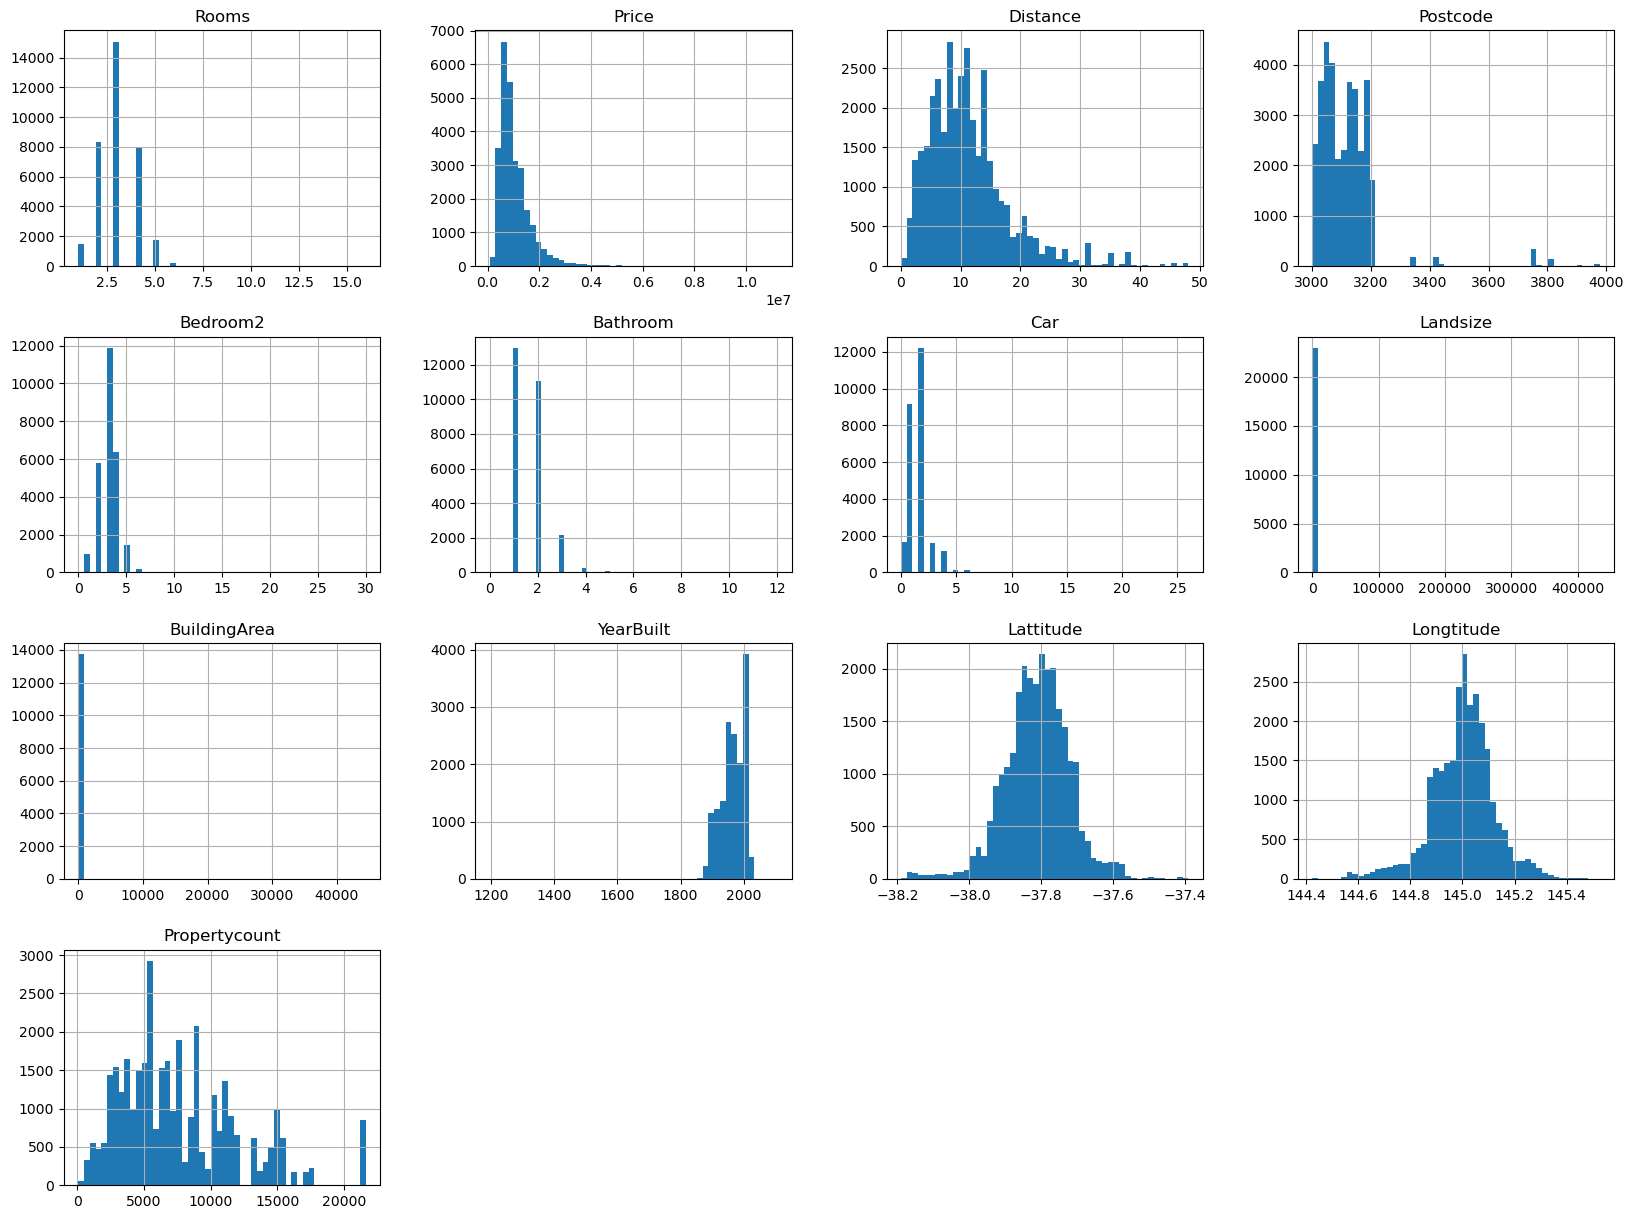

In [15]:
dfhousing.hist(bins=50, figsize=(20,15))

> Vivienda más cara

In [16]:
dfhousing[dfhousing["Price"] == dfhousing["Price"].max()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
25635,Brighton,6 Cole St,4,h,11200000.0,VB,hockingstuart,28/10/2017,10.5,3186.0,...,3.0,2.0,1400.0,NaN,NaN,Bayside City Council,-37.89335,144.98643,Southern Metropolitan,10579.0


> Vivienda más barata

In [17]:
dfhousing[dfhousing["Price"] == dfhousing["Price"].min()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
4378,Footscray,202/51 Gordon St,1,u,85000.0,PI,Burnham,3/09/2016,6.4,3011.0,...,1.0,0.0,0.0,NaN,2007.0,Maribyrnong City Council,-37.7911,144.89,Western Metropolitan,7570.0


### Modificación de valores null

In [18]:
# Obtención de la media de los precios
media_precio = dfhousing["Price"].mean()
print(media_precio)

1050173.344955408


> Reemplazo de los valor Nan del precio

In [19]:
df_sin_modificar = dfhousing.copy()
dfhousing["Price"].fillna(media_precio, inplace=True)

> Parseo de las fechas a data de pandas

In [20]:
dfhousing['Date'] = pd.to_datetime(dfhousing['Date'], format='%d/%m/%Y')

In [21]:
dfhousing["Date"]

0       2016-09-03
1       2016-12-03
2       2016-02-04
3       2016-02-04
4       2017-03-04
           ...    
34852   2018-02-24
34853   2018-02-24
34854   2018-02-24
34855   2018-02-24
34856   2018-02-24
Name: Date, Length: 34857, dtype: datetime64[ns]

In [39]:
dfhousing.info()
#data -> fecha de pandas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          34857 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  float64
 18  Longti

> Completado de los datos restantes con **SimpleImputer**

In [22]:
# Importación
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy="mean")

# # Entrenamiento con las columnas deseadas
# si.fit([dfhousing["Distance"],dfhousing["Postcode"],dfhousing["Bedroom2"],dfhousing["Bathroom"],dfhousing["Car"],
#        dfhousing["Landsize"],dfhousing["Postcode"],dfhousing["BuildingArea"],dfhousing["CouncilArea"]])

# si.transform([dfhousing["Distance"],dfhousing["Postcode"],dfhousing["Bedroom2"],dfhousing["Bathroom"],dfhousing["Car"],
#        dfhousing["Landsize"],dfhousing["Postcode"],dfhousing["BuildingArea"],dfhousing["CouncilArea"]])

# dfhousing["Distance"] = si.fit_transform(dfhousing["Distance"].values.reshape(-1, 1))
dfhousing["Postcode"] = si.fit_transform(dfhousing["Postcode"].values.reshape(-1, 1))
dfhousing["Bedroom2"] = si.fit_transform(dfhousing["Bedroom2"].values.reshape(-1, 1))
dfhousing["Bathroom"] = si.fit_transform(dfhousing["Bathroom"].values.reshape(-1, 1))
dfhousing["Car"] = si.fit_transform(dfhousing["Car"].values.reshape(-1, 1))
dfhousing["Landsize"] = si.fit_transform(dfhousing["Landsize"].values.reshape(-1, 1))
dfhousing["Postcode"] = si.fit_transform(dfhousing["Postcode"].values.reshape(-1, 1))
dfhousing["BuildingArea"] = si.fit_transform(dfhousing["BuildingArea"].values.reshape(-1, 1))

si.fit_transform([dfhousing["Distance"],dfhousing["Postcode"],dfhousing["Bedroom2"],dfhousing["Bathroom"],dfhousing["Car"],
       dfhousing["Landsize"],dfhousing["Postcode"],dfhousing["BuildingArea"]])

array([[2.50000000e+00, 2.50000000e+00, 2.50000000e+00, ...,
        6.30000000e+00, 6.30000000e+00, 6.30000000e+00],
       [3.06700000e+03, 3.06700000e+03, 3.06700000e+03, ...,
        3.01300000e+03, 3.01300000e+03, 3.01300000e+03],
       [2.00000000e+00, 2.00000000e+00, 2.00000000e+00, ...,
        2.00000000e+00, 3.08464715e+00, 2.00000000e+00],
       ...,
       [1.26000000e+02, 2.02000000e+02, 1.56000000e+02, ...,
        2.20000000e+02, 5.93598993e+02, 2.50000000e+02],
       [3.06700000e+03, 3.06700000e+03, 3.06700000e+03, ...,
        3.01300000e+03, 3.01300000e+03, 3.01300000e+03],
       [1.60256400e+02, 1.60256400e+02, 7.90000000e+01, ...,
        1.20000000e+02, 1.60256400e+02, 1.03000000e+02]])

> Los datos de YearBuilt que sean NaN se rellenarán por los valores más generales agrupados por "Suburb" y "Distance"

In [23]:
dfhousing.YearBuilt.value_counts().sort_index().to_dict()
fill_mode(dfhousing,"Suburb",  "Distance", "YearBuilt")

column name    :  YearBuilt
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  160
--------------------------------
YearBuilt
1970.0    5808
1950.0    5184
1960.0    4090
1900.0    2110
1980.0    1846
          ... 
1884.0       1
1868.0       1
2106.0       1
1897.0       1
1879.0       1
Name: count, Length: 160, dtype: int64


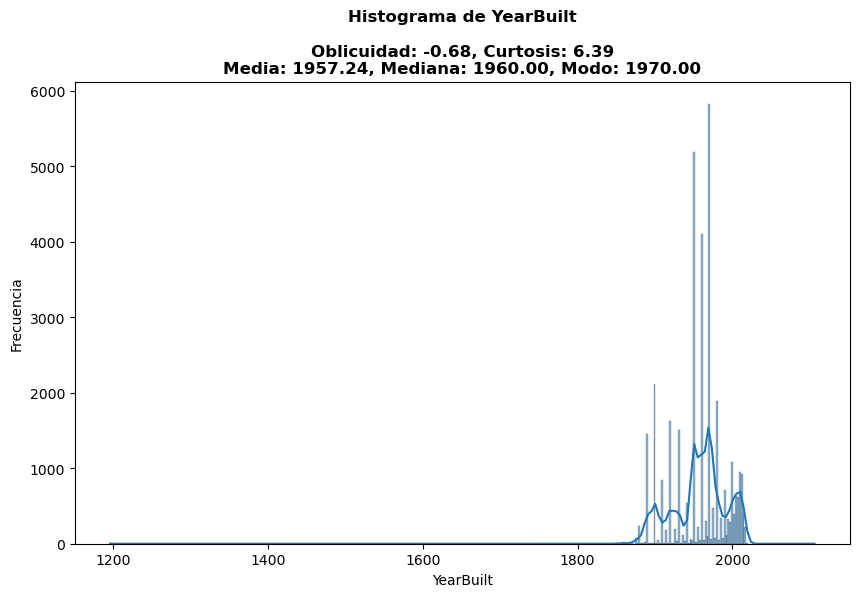

In [27]:
visualize_data(dfhousing, "YearBuilt", plot_type = "histogram")

In [25]:
dfhousing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Suburb         34857 non-null  object        
 1   Address        34857 non-null  object        
 2   Rooms          34857 non-null  int64         
 3   Type           34857 non-null  object        
 4   Price          34857 non-null  float64       
 5   Method         34857 non-null  object        
 6   SellerG        34857 non-null  object        
 7   Date           34857 non-null  datetime64[ns]
 8   Distance       34856 non-null  float64       
 9   Postcode       34857 non-null  float64       
 10  Bedroom2       34857 non-null  float64       
 11  Bathroom       34857 non-null  float64       
 12  Car            34857 non-null  float64       
 13  Landsize       34857 non-null  float64       
 14  BuildingArea   34857 non-null  float64       
 15  YearBuilt      3485

In [33]:
# Con los test quitar los valores que tengan columnas Nan

<bound method Series.isnull of 0              Yarra City Council
1              Yarra City Council
2              Yarra City Council
3              Yarra City Council
4              Yarra City Council
                   ...           
34852    Maribyrnong City Council
34853    Maribyrnong City Council
34854    Maribyrnong City Council
34855    Maribyrnong City Council
34856    Maribyrnong City Council
Name: CouncilArea, Length: 34857, dtype: object>